In [1]:
import os
from datetime import datetime, timedelta, timezone
import matplotlib.pyplot as plt
from skyfield.api import load, EarthSatellite
from statistics import mean, stdev, variance

In [2]:
# Load starlink TLE data
def parse_tle_epoch(epoch):
    year = int(epoch[:2])
    if year < 57:
        year += 2000
    else:
        year += 1900
    day_of_year = float(epoch[2:])
    day = int(day_of_year)
    fractional_day = day_of_year - day
    date = datetime(year, 1, 1, tzinfo=timezone.utc) + timedelta(days=day - 1)
    time_of_day = timedelta(days=fractional_day)
    return date + time_of_day

In [3]:
# load tle data and order by time
document_file = 'Starlink_TLE/Single_Satellite_TLE'
satellite_name = 'STARLINK-1007'
tle_file = os.path.join(document_file, f'{satellite_name}.txt')
tle_data = []

with open(tle_file, 'r') as file:
    lines = file.readlines()
    i = 0
    while i < len(lines):
        if lines[i].startswith(satellite_name):
            tle1 = lines[i+1].strip()
            tle2 = lines[i+2].strip()
            tle_epoch = parse_tle_epoch(tle1.split()[3])
            tle_data.append((tle_epoch, tle1, tle2))
            i += 3
        else:
            i += 1

tle_data.sort(key=lambda x: x[0])  # 按历元时间排序

E:\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


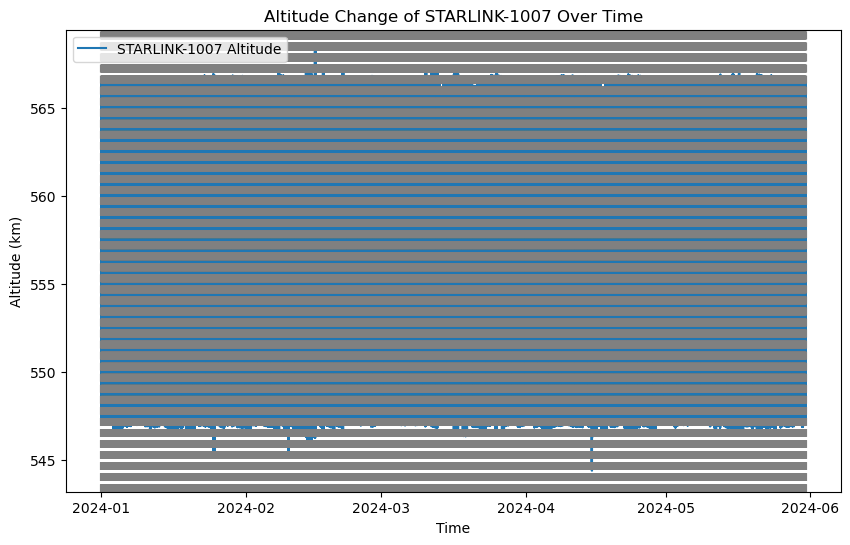

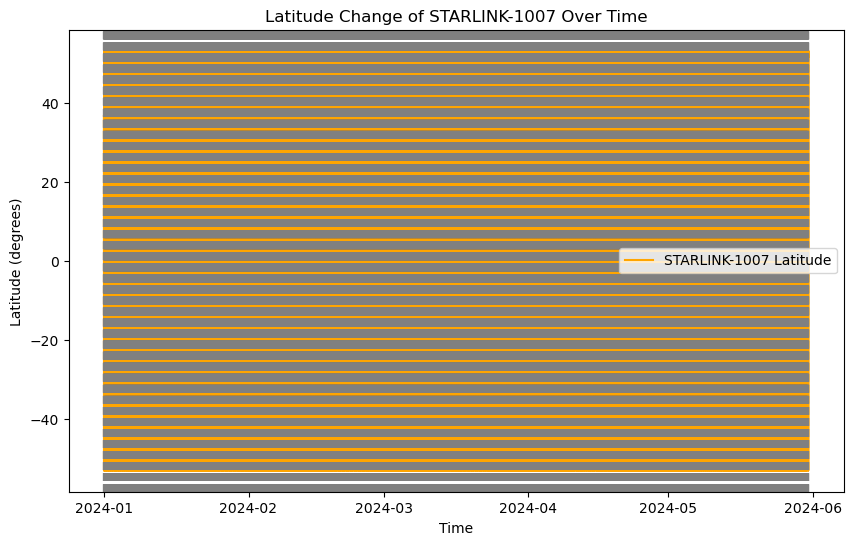

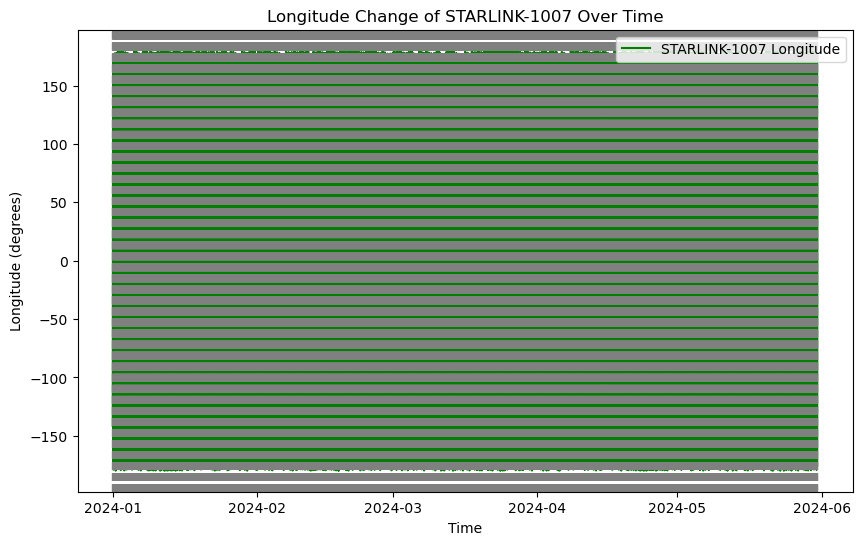

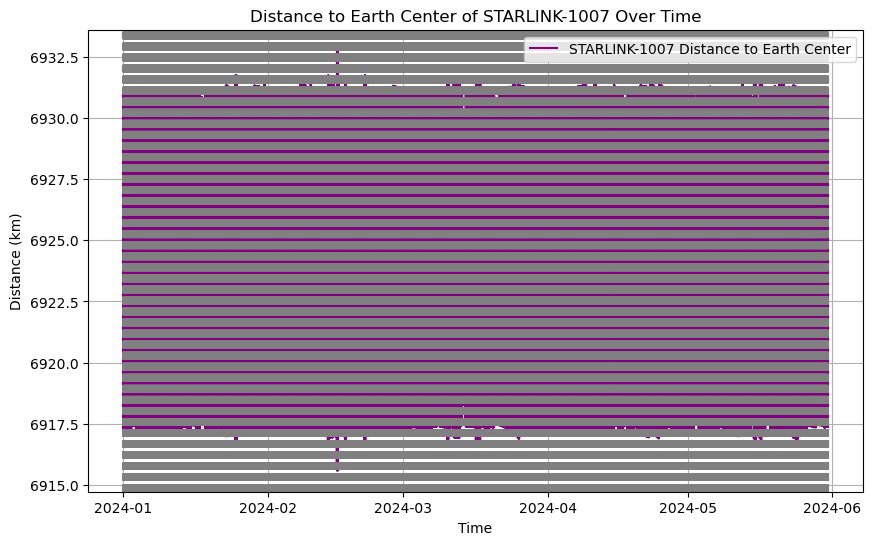

最短距离: 6915.57 km at 2024-02-15 21:42:00+00:00


In [6]:
# gemerate time series
start_time = datetime(2024, 1, 1, tzinfo=timezone.utc)
end_time = datetime(2024, 5, 31, tzinfo=timezone.utc)
time_step = timedelta(minutes = 3)
time_series = [start_time + i * time_step for i in range((end_time - start_time) // time_step + 1)]

# 计算每个时间点的卫星海拔
ts = load.timescale()
# 初始化存储数据的列表
altitudes = []
latitudes = []
longitudes = []
distances = []
periods = []
times = []
tle_update_times = []  # 记录TLE更新的时间点

tle_index = 0
last_tle_index = -1  # 记录上一个使用的TLE索引

# 记录局部最大值时间点
local_max_times = []

for current_time in time_series:
    # 更新TLE数据
    while tle_index < len(tle_data) - 1 and tle_data[tle_index + 1][0] <= current_time:
        tle_index += 1

    if tle_index != last_tle_index:
        tle_update_times.append(current_time)  # 记录TLE更新的时间点
        last_tle_index = tle_index

    latest_tle = tle_data[tle_index]
    # 计算海拔
    satellite = EarthSatellite(latest_tle[1], latest_tle[2], satellite_name, ts)
    current_time_ts = ts.utc(current_time.year, current_time.month, current_time.day, current_time.hour, current_time.minute, current_time.second)
    geocentric = satellite.at(current_time_ts)
    subpoint = geocentric.subpoint()
    altitude = subpoint.elevation.km
    latitude = subpoint.latitude.degrees
    longitude = subpoint.longitude.degrees

    altitudes.append(altitude)
    latitudes.append(latitude)
    longitudes.append(longitude)
    times.append(current_time)

    # 计算卫星距离地心的距离
    distance = geocentric.distance().km
    distances.append(distance)

    # calculate orbit period
    mean_motion = satellite.model.no_kozai
    orbital_period_seconds = (24 * 3600) / mean_motion
    orbital_period_hours = orbital_period_seconds / 3600
    periods.append(orbital_period_hours)

    # 检测局部最大值
    if len(altitudes) > 2 and  altitudes[-2] >  altitudes[-3] and  altitudes[-2] >  altitudes[-1]:
        local_max_times.append(times[-2])


# 绘制海拔变化图
plt.figure(figsize=(10, 6))
plt.plot(times, altitudes, label=f'{satellite_name} Altitude')
for max_time in local_max_times:
    plt.axvline(x=max_time, color='grey', linestyle='--')
plt.title(f'Altitude Change of {satellite_name} Over Time')
plt.xlabel('Time')
plt.ylabel('Altitude (km)')
plt.grid(False)
plt.legend()
plt.show()

# 绘制纬度变化图
plt.figure(figsize=(10, 6))
plt.plot(times, latitudes, label=f'{satellite_name} Latitude', color='orange')
for max_time in local_max_times:
    plt.axvline(x=max_time, color='grey', linestyle='--')
plt.title(f'Latitude Change of {satellite_name} Over Time')
plt.xlabel('Time')
plt.ylabel('Latitude (degrees)')
plt.grid(False)
plt.legend()
plt.show()

# 绘制经度变化图
plt.figure(figsize=(10, 6))
plt.plot(times, longitudes, label=f'{satellite_name} Longitude', color='green')
for max_time in local_max_times:
    plt.axvline(x=max_time, color='grey', linestyle='--')
plt.title(f'Longitude Change of {satellite_name} Over Time')
plt.xlabel('Time')
plt.ylabel('Longitude (degrees)')
plt.grid(False)
plt.legend()
plt.show()

# 绘制距离地心的变化图
plt.figure(figsize=(10, 6))
plt.plot(times, distances, label=f'{satellite_name} Distance to Earth Center', color='purple')
for max_time in local_max_times:
    plt.axvline(x=max_time, color='grey', linestyle='--')
plt.title(f'Distance to Earth Center of {satellite_name} Over Time')
plt.xlabel('Time')
plt.ylabel('Distance (km)')
plt.grid(True)
plt.legend()
plt.show()

# 找到最短距离
min_distance = min(distances)
min_distance_time = times[distances.index(min_distance)]
print(f'最短距离: {min_distance:.2f} km at {min_distance_time}')

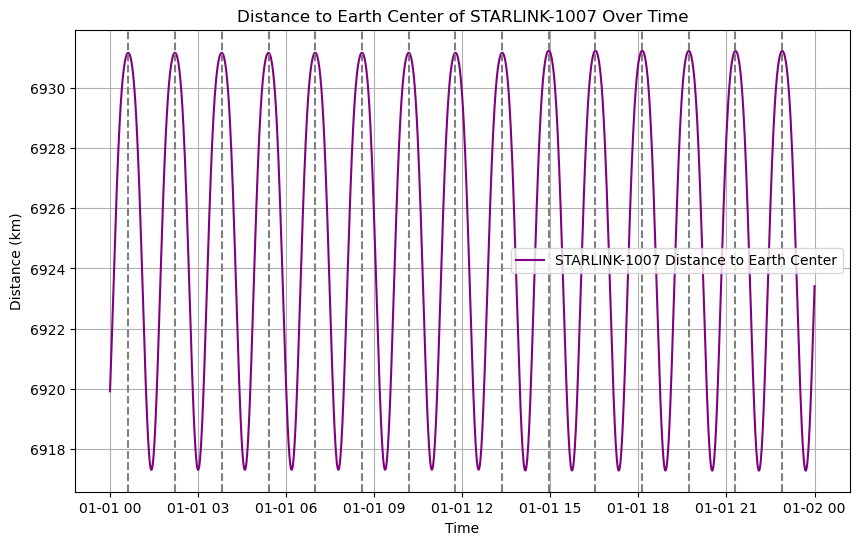

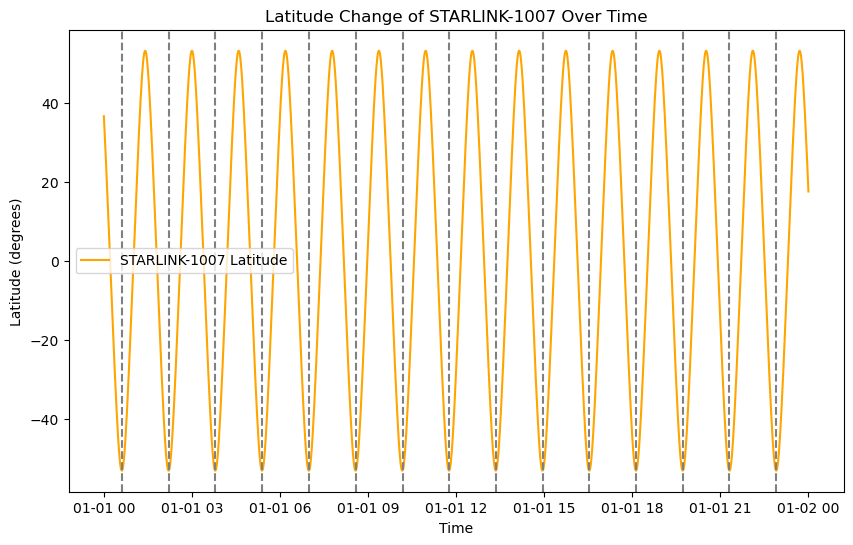

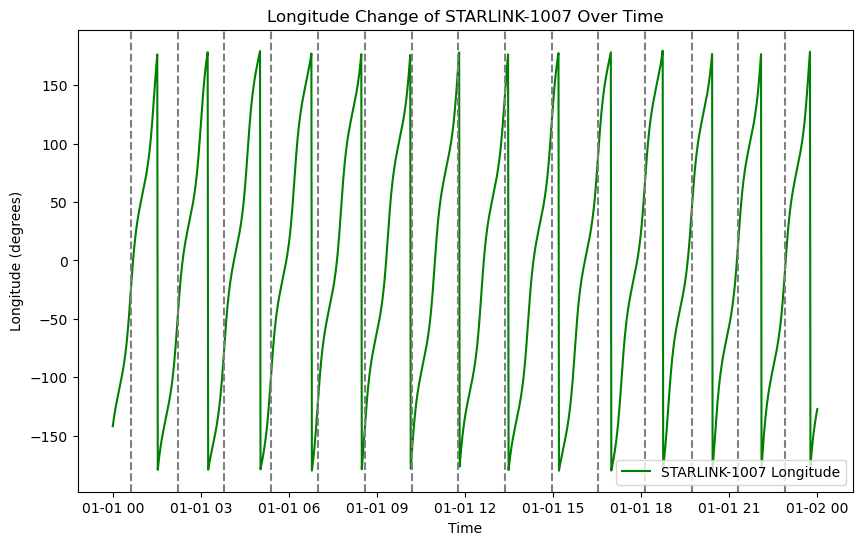

最短距离: 6917.27 km at 2024-01-01 23:42:00+00:00


In [5]:
# gemerate time series
start_time = datetime(2024, 1, 1, tzinfo=timezone.utc)
end_time = datetime(2024, 1, 2, tzinfo=timezone.utc)
time_step = timedelta(minutes = 1)
time_series = [start_time + i * time_step for i in range((end_time - start_time) // time_step + 1)]

# 计算每个时间点的卫星海拔
ts = load.timescale()
# 初始化存储数据的列表
latitudes = []
longitudes = []
distances = []
periods = []
times = []
tle_update_times = []  # 记录TLE更新的时间点

tle_index = 0
last_tle_index = -1  # 记录上一个使用的TLE索引

# 记录局部最大值时间点
local_max_times = []

for current_time in time_series:
    # 更新TLE数据
    while tle_index < len(tle_data) - 1 and tle_data[tle_index + 1][0] <= current_time:
        tle_index += 1

    if tle_index != last_tle_index:
        tle_update_times.append(current_time)  # 记录TLE更新的时间点
        last_tle_index = tle_index

    latest_tle = tle_data[tle_index]
    # 计算海拔
    satellite = EarthSatellite(latest_tle[1], latest_tle[2], satellite_name, ts)
    current_time_ts = ts.utc(current_time.year, current_time.month, current_time.day, current_time.hour, current_time.minute, current_time.second)
    geocentric = satellite.at(current_time_ts)
    subpoint = geocentric.subpoint()
    latitude = subpoint.latitude.degrees
    longitude = subpoint.longitude.degrees

    latitudes.append(latitude)
    longitudes.append(longitude)
    times.append(current_time)

    # 计算卫星距离地心的距离
    distance = geocentric.distance().km
    distances.append(distance)

    # calculate orbit period
    mean_motion = satellite.model.no_kozai
    orbital_period_seconds = (24 * 3600) / mean_motion
    orbital_period_hours = orbital_period_seconds / 3600
    periods.append(orbital_period_hours)

    # 检测局部最大值
    if len(distances) > 2 and  distances[-2] >  distances[-3] and  distances[-2] >  distances[-1]:
        local_max_times.append(times[-2])


# 绘制距离地心的变化图
plt.figure(figsize=(10, 6))
plt.plot(times, distances, label=f'{satellite_name} Distance to Earth Center', color='purple')
for max_time in local_max_times:
    plt.axvline(x=max_time, color='grey', linestyle='--')
plt.title(f'Distance to Earth Center of {satellite_name} Over Time')
plt.xlabel('Time')
plt.ylabel('Distance (km)')
plt.grid(True)
plt.legend()
plt.show()

# 绘制纬度变化图
plt.figure(figsize=(10, 6))
plt.plot(times, latitudes, label=f'{satellite_name} Latitude', color='orange')
for max_time in local_max_times:
    plt.axvline(x=max_time, color='grey', linestyle='--')
plt.title(f'Latitude Change of {satellite_name} Over Time')
plt.xlabel('Time')
plt.ylabel('Latitude (degrees)')
plt.grid(False)
plt.legend()
plt.show()

# 绘制经度变化图
plt.figure(figsize=(10, 6))
plt.plot(times, longitudes, label=f'{satellite_name} Longitude', color='green')
for max_time in local_max_times:
    plt.axvline(x=max_time, color='grey', linestyle='--')
plt.title(f'Longitude Change of {satellite_name} Over Time')
plt.xlabel('Time')
plt.ylabel('Longitude (degrees)')
plt.grid(False)
plt.legend()
plt.show()



# 找到最短距离
min_distance = min(distances)
min_distance_time = times[distances.index(min_distance)]
print(f'最短距离: {min_distance:.2f} km at {min_distance_time}')

轨道近地点 在纬度最高点（北半球）
轨道远地点 在纬度最低点（南半球）
北半球通信密度大，因此轨道在北半球更加靠近地球

In [34]:
import numpy as np
from scipy.stats import pearsonr
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import pandas as pd

# Function to segment the data based on local max times
def segment_data(times, data, local_max_times):
    segments = []
    start_index = 0
    for max_time in local_max_times:
        end_index = times.index(max_time)
        segments.append(data[start_index:end_index+1])
        start_index = end_index
    segments.append(data[start_index:])
    return segments

def calculate_dtw_similarity(segment1, segment2):
    distance, _ = fastdtw(segment1, segment2, dist=lambda x, y: euclidean([x], [y]))
    return distance

In [74]:
# Segment the distance data based on local max times
distance_segments = segment_data(times, distances, local_max_times)

segment_dtw_similarities = []
for i in range(len(distance_segments) - 2):
    dtw_similarity = calculate_dtw_similarity(distance_segments[i], distance_segments[i + 1])
    segment_dtw_similarities.append(dtw_similarity)

similarities_df = pd.DataFrame(segment_dtw_similarities, columns=['DTW Similarity'])
print(similarities_df)
similarities_df.to_csv('DTW_Similarities.csv', index=False)



    DTW Similarity
0       307.898320
1        12.568120
2        12.565861
3        12.568798
4        12.563738
5        12.568593
6        12.562024
7        12.566413
8         9.956836
9        12.582622
10       12.628672
11       11.292290
12       11.918180
13       12.631951


In [42]:
from fastdtw import fastdtw
from scipy.spatial.distance import euclidean
import numpy as np

# Example time series sequences
sequence1 = np.array([1, 2, 3, 4, 5, 6])
sequence2 = np.array([2, 3, 4, 5, 6])

# Calculate DTW distance using a lambda function for the distance metric
distance, path = fastdtw(sequence1, sequence2, dist=lambda x, y: euclidean([x], [y]))

print("DTW Distance:", distance)
print("Optimal Path:", path)

DTW Distance: 1.0
Optimal Path: [(0, 0), (1, 0), (2, 1), (3, 2), (4, 3), (5, 4)]


分析更新TLE在短期的影响

In [55]:
# gemerate time series
start_time = datetime(2024, 1, 1, tzinfo=timezone.utc)
end_time = datetime(2024, 1, 3, tzinfo=timezone.utc)
time_step = timedelta(minutes = 1)
time_series = [start_time + i * time_step for i in range((end_time - start_time) // time_step + 1)]

# 计算每个时间点的卫星海拔
ts = load.timescale()
# 初始化存储数据的列表
longitudes_latest = []
distances_latext = []
times = []
tle_update_times = []  # 记录TLE更新的时间点

# 找到start_time之后的第一个TLE数据
first_tle_index = next(i for i, (epoch, _, _) in enumerate(tle_data) if epoch >= start_time)
first_tle = tle_data[first_tle_index]

satellite_first = EarthSatellite(first_tle[1], first_tle[2], satellite_name, ts)

tle_index = 0
last_tle_index = -1  # 记录上一个使用的TLE索引

# 记录局部最大值时间点
local_max_times_latest = []
local_max_times_first = []
# 初始化存储数据的列表
distances_first_tle = []
distances_latest_tle = []
times = []


for current_time in time_series:
     # 使用第一个TLE数据计算
    current_time_ts = ts.utc(current_time.year, current_time.month, current_time.day, current_time.hour, current_time.minute, current_time.second)
    geocentric_first = satellite_first.at(current_time_ts)
    distance_first = geocentric_first.distance().km
    distances_first_tle.append(distance_first)
    
    # 更新TLE数据
    while tle_index < len(tle_data) - 1 and tle_data[tle_index + 1][0] <= current_time:
        tle_index += 1

    if tle_index != last_tle_index:
        tle_update_times.append(current_time)  # 记录TLE更新的时间点
        last_tle_index = tle_index

    latest_tle = tle_data[tle_index]
    # 计算海拔
    satellite_latest = EarthSatellite(latest_tle[1], latest_tle[2], satellite_name, ts)
    geocentric_latest = satellite_latest.at(current_time_ts)
    distance_latest = geocentric_latest.distance().km
    distances_latest_tle.append(distance_latest)
    
    times.append(current_time)

    # 检测局部最大值
    if len(distances_latest_tle) > 2 and  distances_latest_tle[-2] >  distances_latest_tle[-3] and  distances_latest_tle[-2] >  distances_latest_tle[-1]:
        local_max_times_latest.append(times[-2])





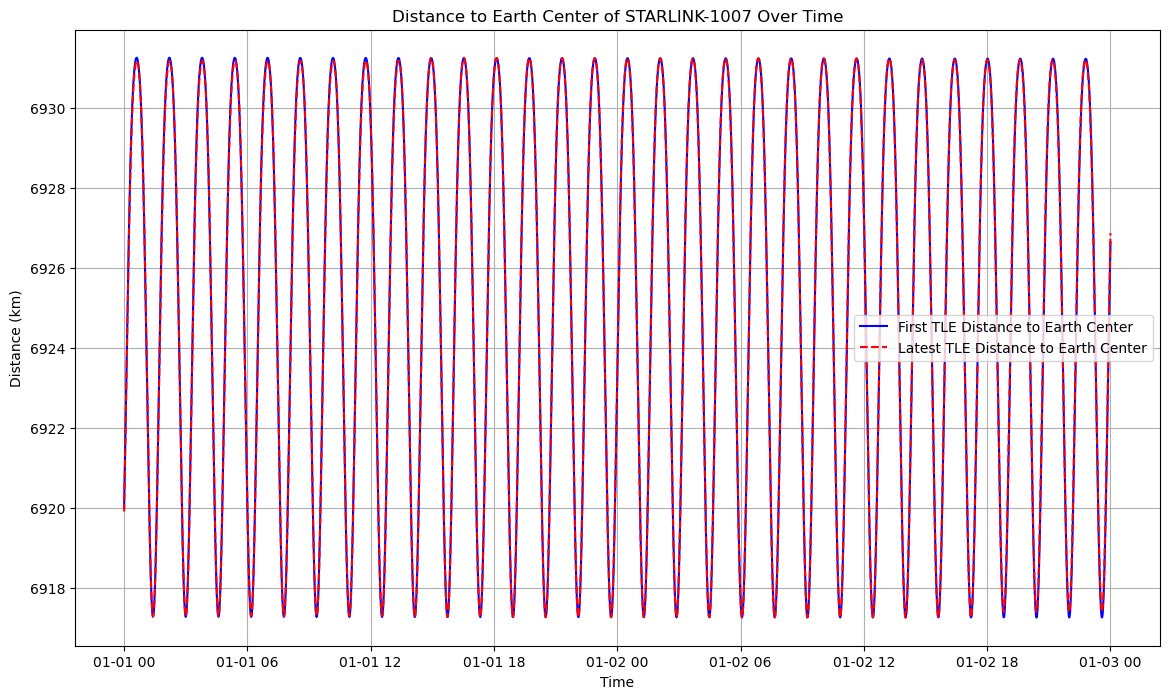

In [56]:
# Plot the distances
plt.figure(figsize=(14, 8))
plt.plot(times, distances_first_tle, label='First TLE Distance to Earth Center', color='blue')
plt.plot(times, distances_latest_tle, label='Latest TLE Distance to Earth Center', color='red', linestyle='--')
plt.title(f'Distance to Earth Center of {satellite_name} Over Time')
plt.xlabel('Time')
plt.ylabel('Distance (km)')
plt.legend()
plt.grid(True)
plt.show()

In [57]:
# Calculate DTW similarity
dtw_distance, path = fastdtw(distances_first_tle, distances_latest_tle, dist=lambda x, y: euclidean([x], [y]))
print(f'DTW Distance between first and latest TLE: {dtw_distance}')


DTW Distance between first and latest TLE: 166.0770691356256


In [76]:
# Segment the distance data based on local max times
distance_segments_first_tle = segment_data(times, distances_first_tle, local_max_times)
distance_segments_latest_tle = segment_data(times, distances_latest_tle, local_max_times)

# Calculate the Pearson correlation coefficient between each pair of segments
dtw_similarities = []
for i in range(1, len(distance_segments_first_tle) - 1):
    #correlation, _ = pearsonr(distance_segments_first_tle[i], distance_segments_latest_tle[i])
    dtw_distance, _  = fastdtw(distance_segments_first_tle[i], distance_segments_latest_tle[i], dist=lambda x, y: euclidean([x], [y]))
    dtw_similarities.append(dtw_distance)

# Output the similarity metrics
segment_correlations

# Output the similarity metrics
similarities_df = pd.DataFrame(dtw_similarities, columns=['DTW Similarity'])
print(similarities_df)
similarities_df.to_csv('DTW_Similarities_Segments.csv', index=False)

    DTW Similarity
0         6.479262
1         6.382703
2         6.453010
3         6.364378
4         6.428965
5         6.412280
6         6.333094
7         6.396694
8         0.917494
9         0.000000
10        0.000000
11        3.691361
12        5.025886
13        5.032280


In [62]:
# Segment the distance data based on local max times
distance_segments_first_tle = segment_data(times, distances_first_tle, local_max_times_latest)
distance_segments_latest_tle = segment_data(times, distances_latest_tle, local_max_times_latest)

In [64]:
len(distance_segments_first_tle)

31

In [65]:
len(distance_segments_latest_tle)

31